In [4]:
!pip install "hopsworks==4.2.*"

In [5]:
!pip install requests matplotlib seaborn confluent-kafka shap xgboost tensorflow

In [6]:
!pip install meteostat tqdm

In [7]:
import hopsworks
print(hopsworks.__version__)

4.2.9


In [8]:
from google.colab import userdata
import pandas as pd
import requests, time, datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
plt.style.use('fivethirtyeight')

In [93]:
API_KEY = userdata.get("OPENWEATHER_API_KEY")

Data Collection

In [94]:
def fetch_lat_lon(city_name, api_key=API_KEY):
  resp = requests.get(f"http://api.openweathermap.org/geo/1.0/direct?q={city_name}&limit=5&appid={api_key}")
  if resp.status_code != 200:
        raise Exception(f"API Error: {resp.text}")
  lat = resp.json()[0]["lat"]
  lon = resp.json()[0]["lon"]
  return lat,lon

In [95]:
city_name="karachi"
lat,lon = fetch_lat_lon(city_name,API_KEY)
print(lat,lon)

24.8546842 67.0207055


In [96]:
#Fetch one year history data
BASE_URL = "http://api.openweathermap.org/data/2.5/air_pollution"
#Backfilling
end = int(time.time())
start = end - (1000*24*3600)
def fetch_aqi_history_data(start=start, end=end, lat=lat, lon=lon, api_key=API_KEY):
    url = f"{BASE_URL}/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={api_key}"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()["list"]

    records = []
    for entry in data:
        ts = pd.to_datetime(entry["dt"], unit="s")
        aqi = entry["main"]["aqi"]
        comps = entry["components"]
        records.append({"timestamp": ts, "aqi": aqi, **comps})
    return pd.DataFrame(records)

In [13]:
from datetime import datetime, timedelta, UTC
from meteostat import Point, Hourly
from tqdm import tqdm

In [14]:
end = int(time.time())
start = end - (1000*24*3600)
def fetch_weather_data(lat=lat, lon=lon, start=start, end=end):
    print("\nFetching weather data from Meteostat...")
    start_dt = datetime.fromtimestamp(start, UTC)
    end_dt = datetime.fromtimestamp(end, UTC)

    start_dt = start_dt.replace(tzinfo=None)
    end_dt = end_dt.replace(tzinfo=None)

    location = Point(lat, lon)
    data = Hourly(location, start_dt, end_dt)
    df_weather = data.fetch()
    drop = ['dwpt', 'snow', 'wpgt', 'tsun', 'coco', 'wdir','prcp']
    df_weather = df_weather.drop(columns=drop)
    df_weather = df_weather.reset_index().rename(columns={'time': 'timestamp'})
    df_weather = df_weather.sort_values("timestamp").reset_index(drop=True)
    print(f"Weather Data fetched: {len(df_weather)} rows")
    return df_weather


In [15]:
df_aqi = fetch_aqi_history_data()

In [16]:
df_weather = fetch_weather_data()


Fetching weather data from Meteostat...
Weather Data fetched: 24000 rows


In [17]:
df_aqi = df_aqi.sort_values("timestamp")
df_weather = df_weather.sort_values("timestamp")

In [18]:
df_aqi.replace(-9999, np.nan, inplace=True)
df_weather.replace(-9999, np.nan, inplace=True)

In [19]:
def merge_and_preprocess(df_aqi, df_weather):
    merged = pd.merge_asof(
        df_aqi.sort_values("timestamp"),
        df_weather.sort_values("timestamp"),
        on="timestamp",
        direction="nearest",
        tolerance=pd.Timedelta("1h")
    )
    # Drop duplicate timestamps if any
    merged = merged.drop_duplicates(subset='timestamp')

    # Forward-fill short weather gaps within same day
    merged['date'] = merged['timestamp'].dt.date
    cols_to_fill = ['temp', 'rhum', 'wspd', 'pres']
    merged[cols_to_fill] = merged.groupby('date')[cols_to_fill].ffill(limit=3)
    merged.drop(columns=['date'], inplace=True)

    merged['us_aqi'] = merged.apply(get_aqi_us, axis=1)
    merged = merged.dropna()

    return merged

In [20]:
history_data = pd.merge_asof(
    df_aqi,
    df_weather,
    on="timestamp",
    direction="nearest",
    tolerance=pd.Timedelta("1h")
)

In [21]:
history_data = history_data.drop_duplicates(subset='timestamp')

In [22]:
history_data['date'] = history_data['timestamp'].dt.date
cols_to_fill = ['temp', 'rhum', 'wspd', 'pres']
history_data[cols_to_fill] = history_data.groupby('date')[cols_to_fill].ffill(limit=3)

In [23]:
history_data.drop(columns=['date'], inplace=True)

In [24]:
print(history_data)

                timestamp  aqi      co    no   no2      o3   so2  pm2_5  \
0     2023-02-09 18:00:00  3.0  323.77  0.00  6.85   71.53  2.65  34.14   
1     2023-02-09 19:00:00  3.0  297.07  0.00  5.91   69.38  2.29  34.64   
2     2023-02-09 20:00:00  3.0  263.69  0.00  4.58   69.38  2.09  34.69   
3     2023-02-09 21:00:00  3.0  253.68  0.00  3.56   69.38  2.24  34.02   
4     2023-02-09 22:00:00  3.0  250.34  0.00  2.87   67.23  2.26  31.66   
...                   ...  ...     ...   ...   ...     ...   ...    ...   
23467 2025-11-05 13:00:00  4.0  290.03  0.01  1.71  165.82  5.36  64.44   
23468 2025-11-05 14:00:00  4.0  281.63  0.00  1.33  163.81  5.17  63.81   
23469 2025-11-05 15:00:00  4.0  269.52  0.00  1.03  161.75  5.00  62.62   
23470 2025-11-05 16:00:00  4.0  256.43  0.00  0.87  158.88  4.86  61.17   
23471 2025-11-05 17:00:00  4.0  246.55  0.00  0.78  156.62  4.80  60.04   

         pm10   nh3  temp  rhum  wspd    pres  
0       82.71  1.84  21.6  93.0  27.4  1012.5  
1  

In [25]:
def get_aqi_us(components):
    # Pollutant concentration breakpoints (in μg/m³) from the openweather table
    POLLUTANT_CONCENTRATIONS = {
        'co': [(0, 4400), (4401, 9400), (9401, 12400), (12401, 15400), (15401, 30400), (30401, 40400), (40401, 50400)],
        'no2': [(0, 100), (101, 200), (201, 700), (701, 1200), (1201, 2340), (2341, 3090), (3091, 4048)],
        'o3': [(0, 106), (107, 138), (139, 168), (169, 208), (209, 748)],
        'so2': [(0, 88), (89, 200), (201, 786), (787, 1572), (1573, 2100)],
        'pm2_5': [(0, 12.0), (12.1, 35.4), (35.5, 55.4), (55.5, 150.4), (150.5, 250.4), (250.5, 350.4), (350.5, 500.4)],
        'pm10': [(0, 54), (55, 154), (155, 254), (255, 354), (355, 424), (425, 504), (505, 604)]
    }

    # Corresponding AQI levels from the table
    AQI_LEVELS = [(0, 50), (51, 100), (101, 150), (151, 200), (201, 300), (301, 400), (401, 500)]

    def get_pollutant_aqi(concentration, pollutant):
        if concentration is None or np.isnan(concentration) or pollutant not in POLLUTANT_CONCENTRATIONS:
            return None

        for i, (conc_low, conc_high) in enumerate(POLLUTANT_CONCENTRATIONS[pollutant]):
            if conc_low <= concentration <= conc_high:
                aqi_low, aqi_high = AQI_LEVELS[i]
                try:
                    aqi = ((aqi_high - aqi_low) / (conc_high - conc_low)) * (concentration - conc_low) + aqi_low
                    return round(aqi)
                except ZeroDivisionError:
                    return aqi_low

        max_range = POLLUTANT_CONCENTRATIONS[pollutant]
        if max_range and concentration > max_range[-1][1]:
            return AQI_LEVELS[-1][1]

        return None
    sub_indices = [
        get_pollutant_aqi(components.get('co'), 'co'),
        get_pollutant_aqi(components.get('no2'), 'no2'),
        get_pollutant_aqi(components.get('o3'), 'o3'),
        get_pollutant_aqi(components.get('so2'), 'so2'),
        get_pollutant_aqi(components.get('pm2_5'), 'pm2_5'),
        get_pollutant_aqi(components.get('pm10'), 'pm10')
    ]

    valid_indices = [idx for idx in sub_indices if idx is not None]

    if not valid_indices:
        return np.nan

    return max(valid_indices)

In [26]:
history_data['us_aqi'] = history_data.apply(get_aqi_us, axis=1)

In [27]:
history_data = history_data.dropna()

In [28]:
history_data = history_data.drop(columns=['aqi'])

In [29]:
print(history_data)

                timestamp      co    no   no2      o3   so2  pm2_5    pm10  \
0     2023-02-09 18:00:00  323.77  0.00  6.85   71.53  2.65  34.14   82.71   
1     2023-02-09 19:00:00  297.07  0.00  5.91   69.38  2.29  34.64   88.24   
2     2023-02-09 20:00:00  263.69  0.00  4.58   69.38  2.09  34.69   87.80   
3     2023-02-09 21:00:00  253.68  0.00  3.56   69.38  2.24  34.02   84.00   
4     2023-02-09 22:00:00  250.34  0.00  2.87   67.23  2.26  31.66   77.66   
...                   ...     ...   ...   ...     ...   ...    ...     ...   
23467 2025-11-05 13:00:00  290.03  0.01  1.71  165.82  5.36  64.44  147.75   
23468 2025-11-05 14:00:00  281.63  0.00  1.33  163.81  5.17  63.81  146.88   
23469 2025-11-05 15:00:00  269.52  0.00  1.03  161.75  5.00  62.62  145.92   
23470 2025-11-05 16:00:00  256.43  0.00  0.87  158.88  4.86  61.17  144.28   
23471 2025-11-05 17:00:00  246.55  0.00  0.78  156.62  4.80  60.04  143.07   

        nh3  temp  rhum  wspd    pres  us_aqi  
0      1.84  21

In [30]:
print("Shape of data:", history_data.shape)
print("\nColumn Summary:")
print(history_data.info())

Shape of data: (23468, 14)

Column Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 23468 entries, 0 to 23471
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  23468 non-null  datetime64[ns]
 1   co         23468 non-null  float64       
 2   no         23468 non-null  float64       
 3   no2        23468 non-null  float64       
 4   o3         23468 non-null  float64       
 5   so2        23468 non-null  float64       
 6   pm2_5      23468 non-null  float64       
 7   pm10       23468 non-null  float64       
 8   nh3        23468 non-null  float64       
 9   temp       23468 non-null  Float64       
 10  rhum       23468 non-null  Float64       
 11  wspd       23468 non-null  Float64       
 12  pres       23468 non-null  Float64       
 13  us_aqi     23468 non-null  int64         
dtypes: Float64(4), datetime64[ns](1), float64(8), int64(1)
memory usage: 2.8 MB
None


In [31]:
print(history_data.describe())

                           timestamp            co            no  \
count                          23468  23468.000000  23468.000000   
mean   2024-06-23 09:14:18.275098112    974.885784      5.637648   
min              2023-02-09 18:00:00     66.760000      0.000000   
25%              2023-10-18 05:45:00    226.970000      0.000000   
50%              2024-06-21 17:30:00    353.810000      0.010000   
75%              2025-02-24 06:15:00    961.300000      1.750000   
max              2025-11-05 17:00:00  21575.930000    379.090000   
std                              NaN   1624.457271     20.293987   

                no2            o3           so2         pm2_5          pm10  \
count  23468.000000  23468.000000  23468.000000  23468.000000  23468.000000   
mean      25.329141     59.919211      9.905334     61.751893    117.135231   
min        0.020000      0.000000      0.060000      0.000000      0.000000   
25%        1.780000     36.840000      1.360000     16.520000     55.21

In [32]:
history_data.isnull().sum()

,0
timestamp,0
co,0
no,0
no2,0
o3,0
so2,0
pm2_5,0
pm10,0
nh3,0
temp,0


In [33]:
history_data = history_data.set_index('timestamp')
history_data.index = pd.to_datetime(history_data.index)

In [34]:
history_data = history_data.resample("1H").asfreq()

In [35]:
print(history_data.index)

DatetimeIndex(['2023-02-09 18:00:00', '2023-02-09 19:00:00',
               '2023-02-09 20:00:00', '2023-02-09 21:00:00',
               '2023-02-09 22:00:00', '2023-02-09 23:00:00',
               '2023-02-10 00:00:00', '2023-02-10 01:00:00',
               '2023-02-10 02:00:00', '2023-02-10 03:00:00',
               ...
               '2025-11-05 08:00:00', '2025-11-05 09:00:00',
               '2025-11-05 10:00:00', '2025-11-05 11:00:00',
               '2025-11-05 12:00:00', '2025-11-05 13:00:00',
               '2025-11-05 14:00:00', '2025-11-05 15:00:00',
               '2025-11-05 16:00:00', '2025-11-05 17:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=24000, freq='H')


In [36]:
df = history_data.copy()
df = df.us_aqi

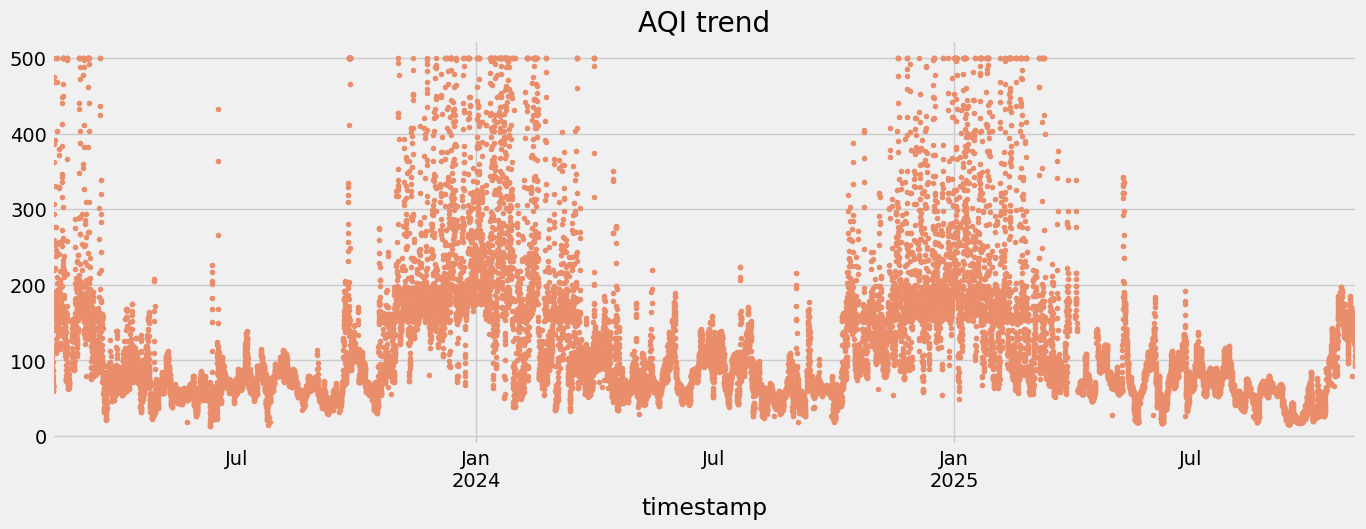

In [37]:
df.plot(style='.',figsize=(15, 5),color=sns.color_palette("flare"),title='AQI trend')
plt.show()

**Very clear seasonal and monthly pattern.**

In [38]:
history_data.to_csv("history_aqi.csv", index=False, encoding="utf-8")
print(f"Saved data to history_aqi.csv")

Saved data to history_aqi.csv


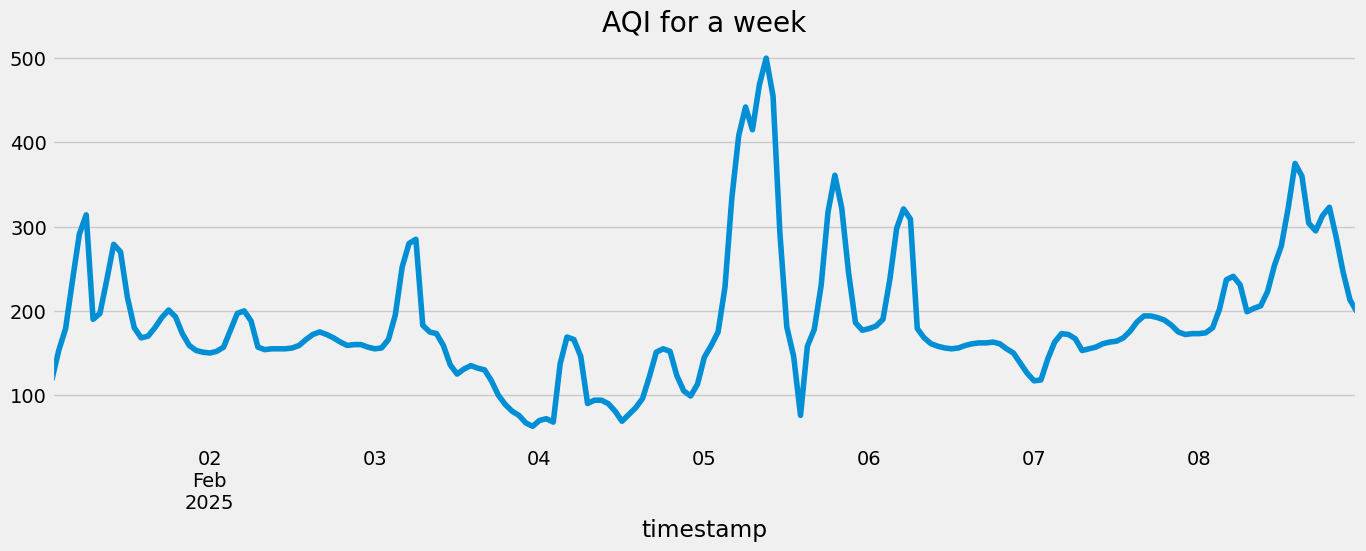

In [39]:
df.loc[(df.index > '02-01-2025') & (df.index < '02-09-2025')].plot(figsize=(15, 5), title='AQI for a week')
plt.show()

**Weekly fluctutations as well**

In [40]:
import hopsworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

In [41]:
HOPSWORKS_API_KEY = userdata.get("HOPSWORKS_API_KEY")

Feature Creation , Selection and Engineering


In [42]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

    df['sin_dayofweek'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['cos_dayofweek'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

In [43]:
def add_lags(df):
    df['onedaylag'] = df['us_aqi'].shift(24)
    df['twodaylag'] = df['us_aqi'].shift(48)
    df['threedaylag'] = df['us_aqi'].shift(72)
    df["aqi_roll_std_3"] = df["us_aqi"].rolling(72).std().shift(24)
    df["us_aqi_roll_mean_3d"] = df["us_aqi"].rolling(72).mean().shift(24)
    df["pm2_5_rhum"] = df["pm2_5"] * df["rhum"]  # humidity amplifies PM2.5 concentration
    df["no2_temp"] = df["no2"] * df["temp"]      # hot weather increases NO2 dispersion/reaction
    return df

In [44]:
def create_targets(df):
  df['aqi_24'] = df['us_aqi'].rolling(window=24).mean().shift(-24)
  return df

In [45]:
data = history_data.copy()

In [46]:
data = create_features(data)
data = add_lags(data)
data = create_targets(data)

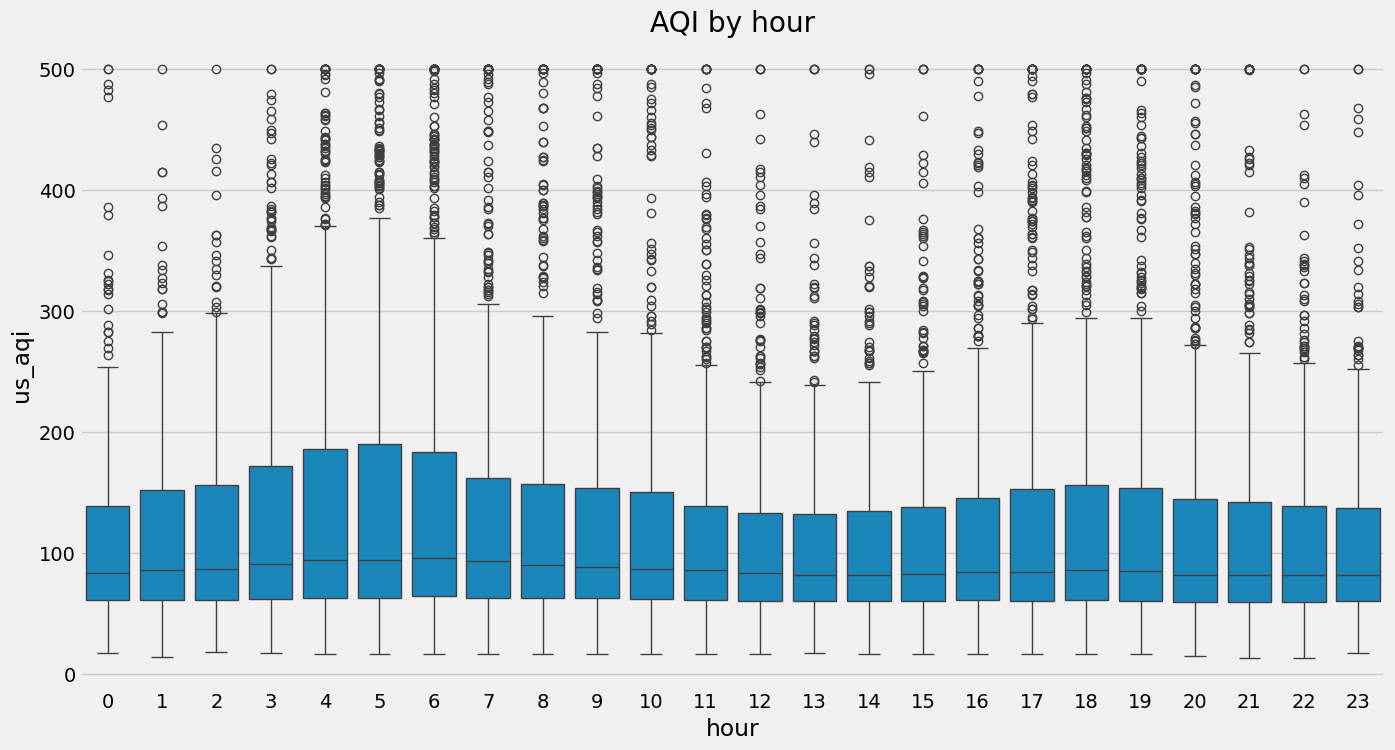

In [47]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='hour', y='us_aqi')
ax.set_title('AQI by hour')
plt.show()

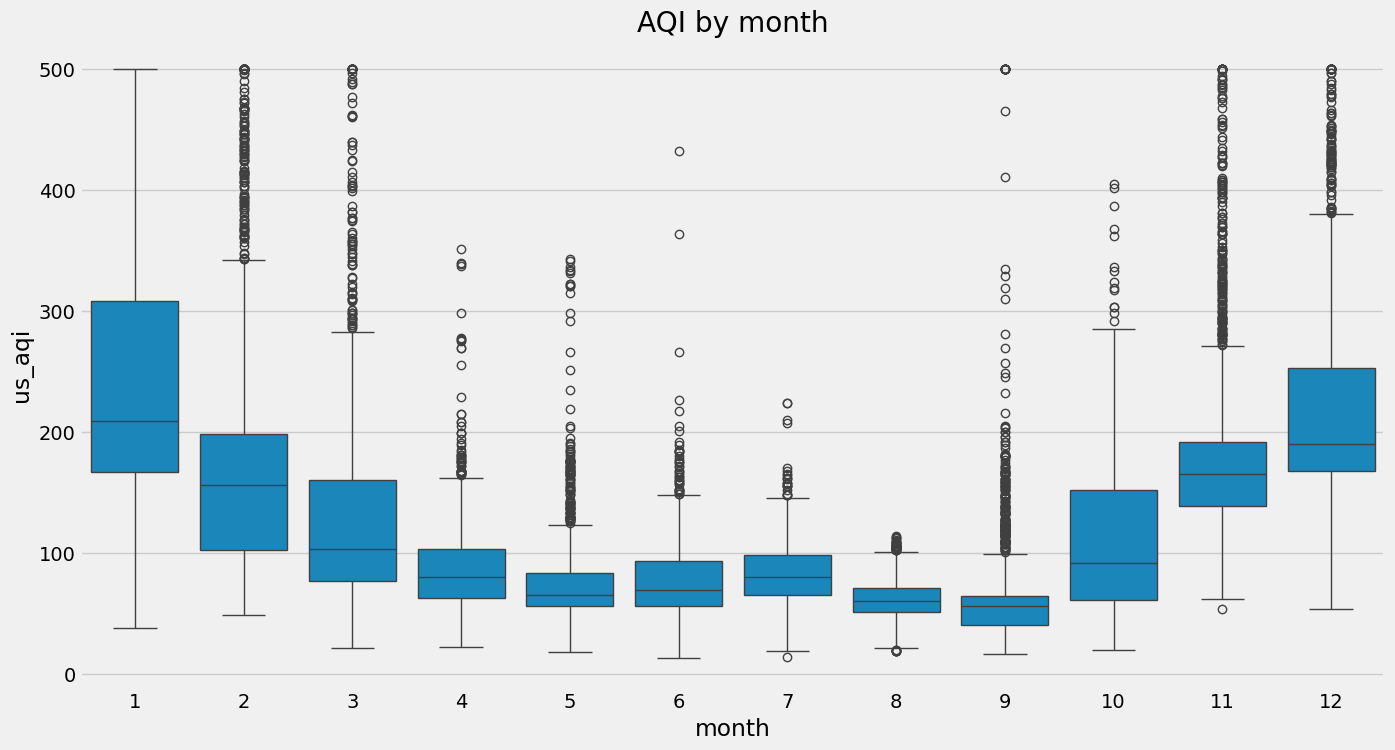

In [48]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='month', y='us_aqi')
ax.set_title('AQI by month')
plt.show()

**Hourly and Monthly fluctuations as well**

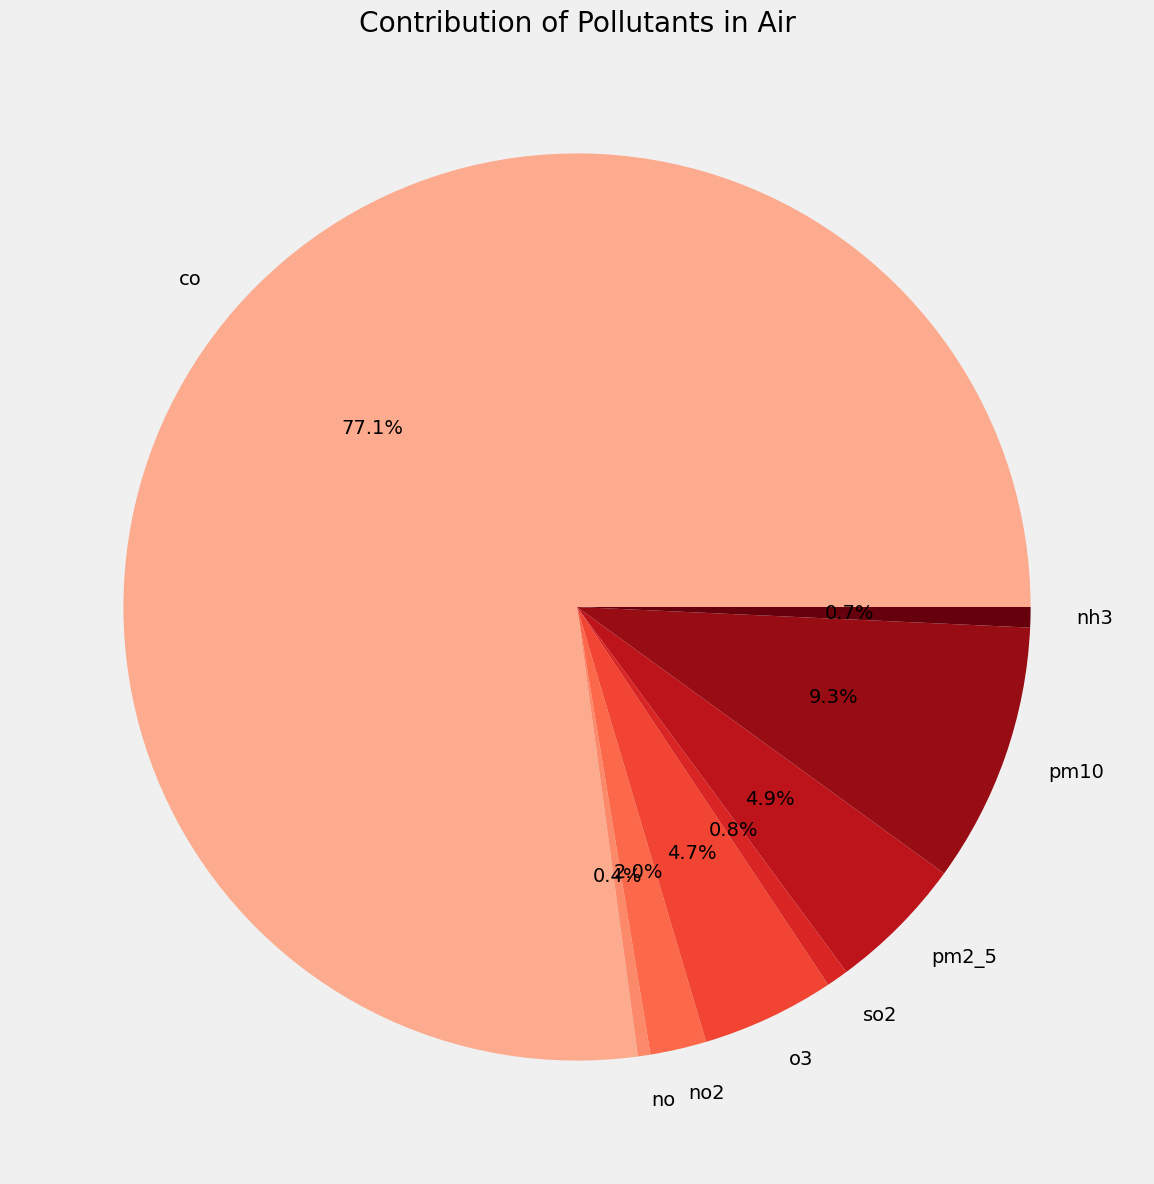

In [49]:
pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
avg_values = data[pollutants].mean()

plt.figure(figsize=(14,14))
plt.pie(avg_values, labels=pollutants, autopct='%1.1f%%',colors=plt.cm.Reds(np.linspace(0.3, 1, len(pollutants))))
plt.title('Contribution of Pollutants in Air')
plt.savefig('Contribution of Pollutants in Air')
plt.show()


Most critical pollutant in Karachi: co (Average concentration: 974.89)


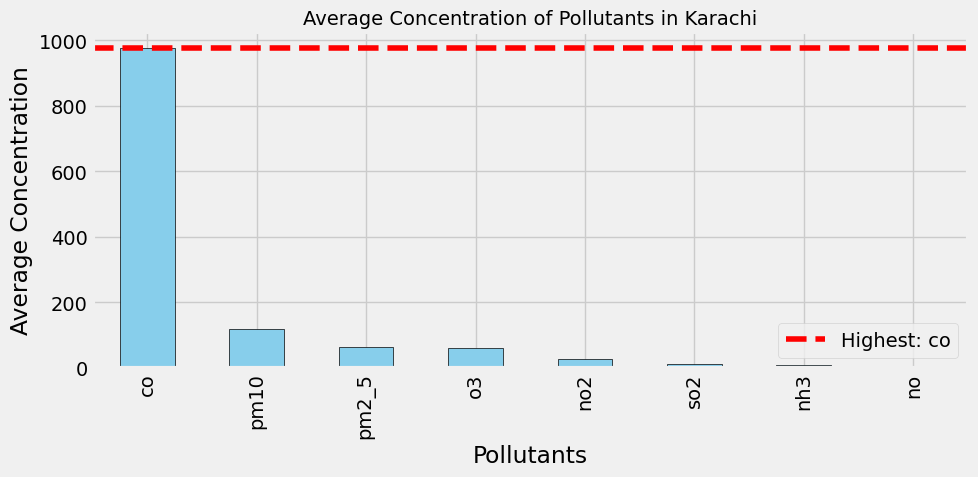

In [50]:
pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
avg_concentrations = data[pollutants].mean().sort_values(ascending=False)
most_critical = avg_concentrations.idxmax()
most_value = avg_concentrations.max()
print(f"Most critical pollutant in Karachi: {most_critical} (Average concentration: {most_value:.2f})")

plt.figure(figsize=(10, 5))
avg_concentrations.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Concentration of Pollutants in Karachi', fontsize=14)
plt.ylabel('Average Concentration')
plt.xlabel('Pollutants')
plt.axhline(y=most_value, color='red', linestyle='--', label=f'Highest: {most_critical}')
plt.legend()
plt.tight_layout()
plt.savefig('Average Concentration of Pollutants in Karachi.png')
plt.show()


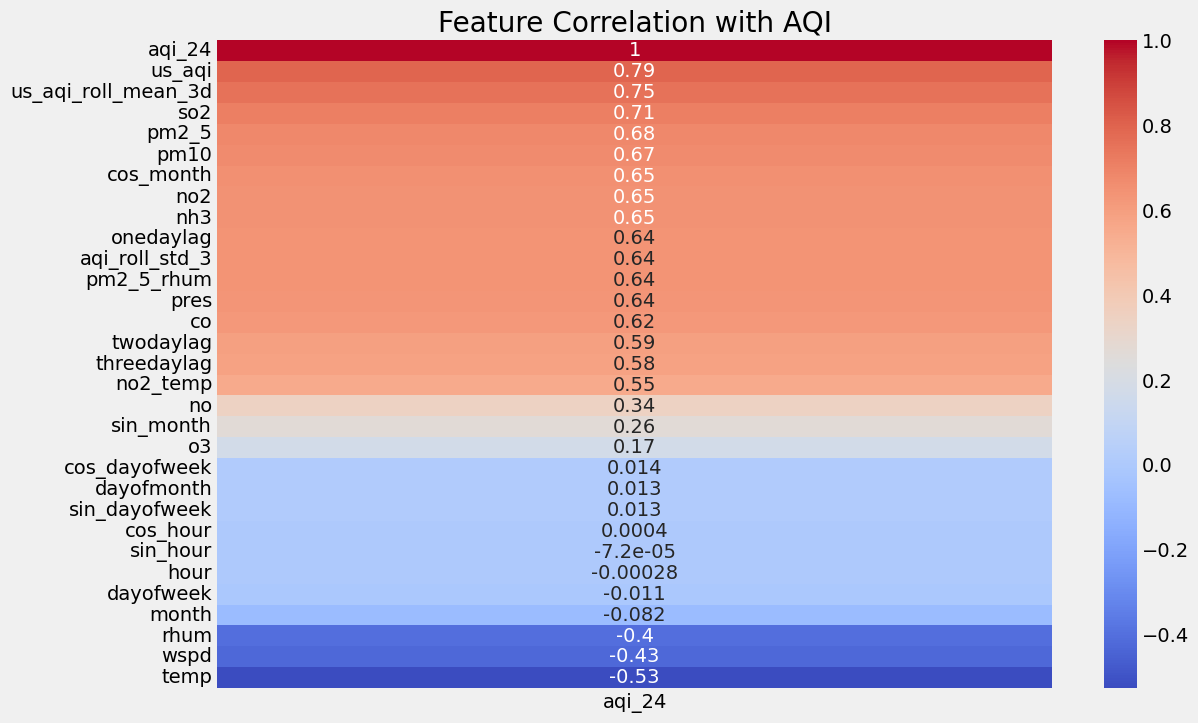

In [51]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['aqi_24']].sort_values(by='aqi_24', ascending=False), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with AQI')
plt.show()

In [52]:
df_numeric = data.copy()
df_numeric = df_numeric.drop(columns=['aqi_24'])

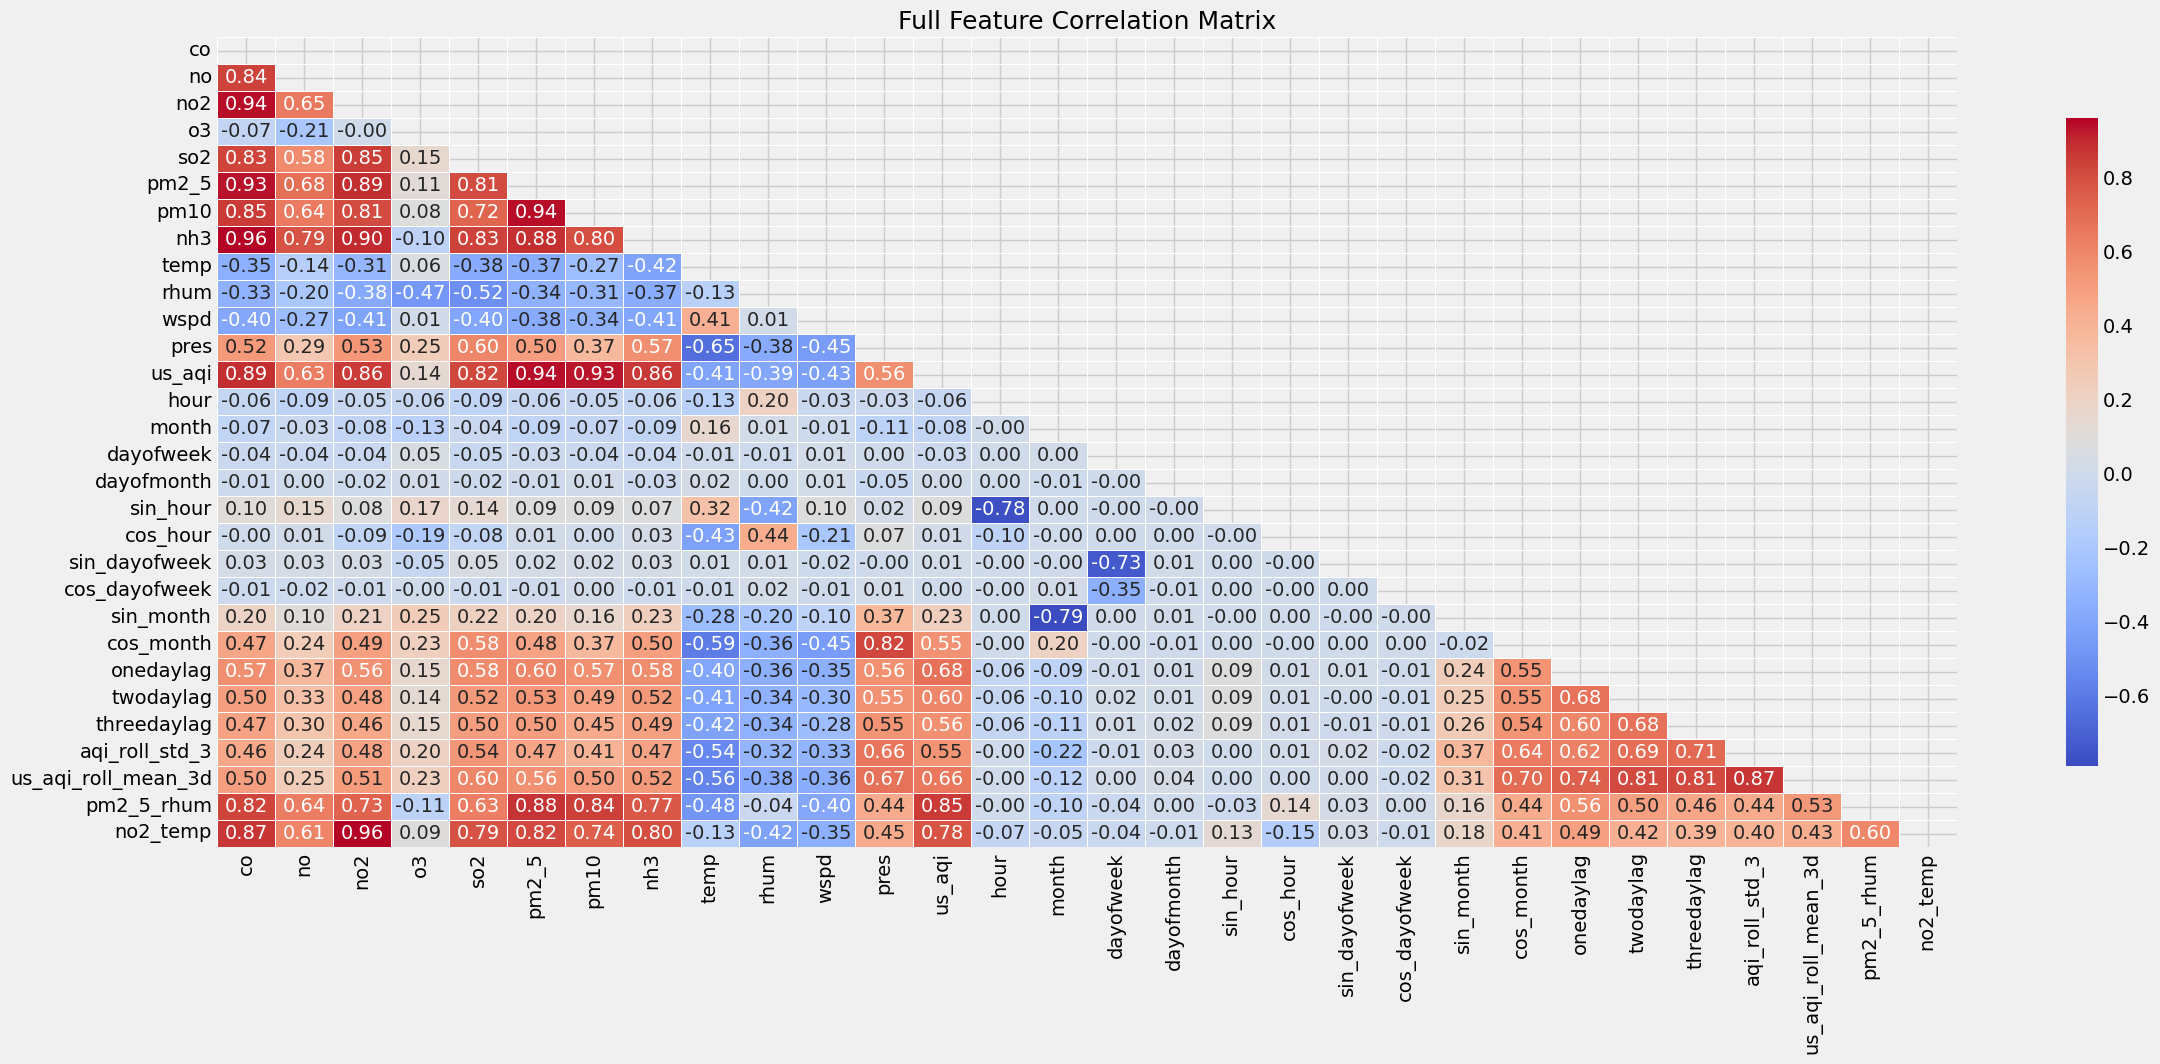

In [53]:
df_numeric = df_numeric.select_dtypes(include=[np.number])
full_corr_matrix = df_numeric.corr()
plt.figure(figsize=(25, 10))
mask = np.triu(np.ones_like(full_corr_matrix, dtype=bool))

sns.heatmap(
    full_corr_matrix,
    mask = mask,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Full Feature Correlation Matrix', fontsize=18)
plt.show()

In [54]:
features_to_drop = ['co','nh3','no','o3','hour','dayofweek','month']
df_numeric= df_numeric.drop(columns=features_to_drop)

In [55]:
df_numeric = df_numeric.drop(columns=['us_aqi'])

In [56]:
features_to_drop = ['co', 'nh3','no','o3']
data=data.drop(columns=features_to_drop)

In [57]:
data = data.drop(columns=['hour', 'dayofweek', 'month'])

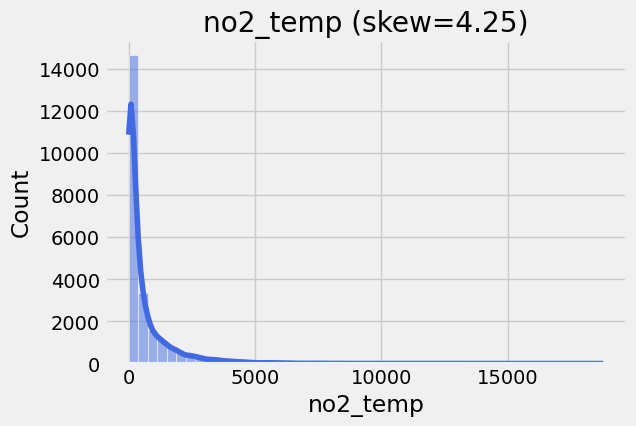

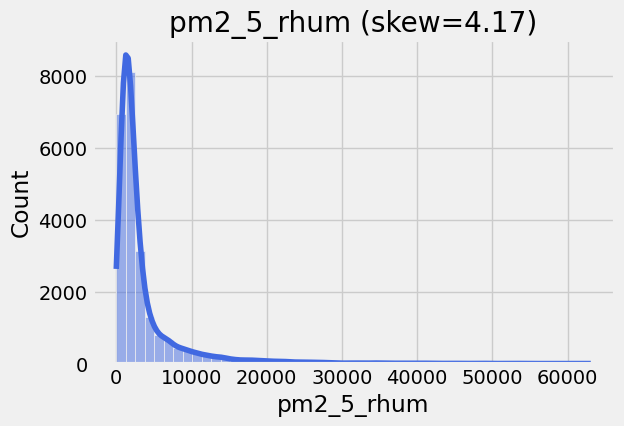

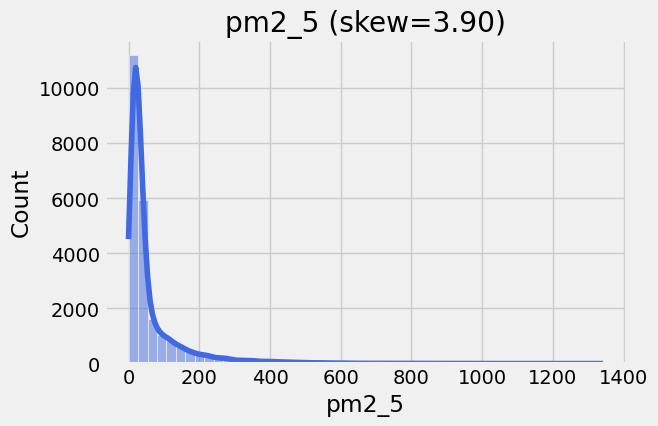

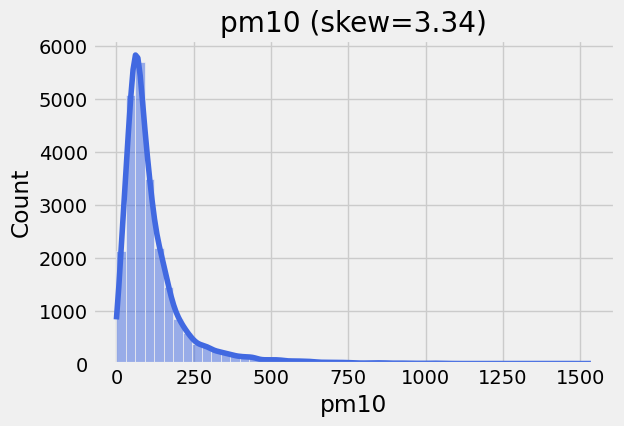

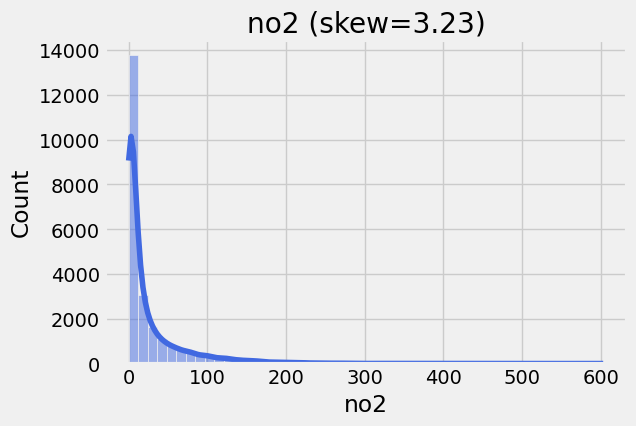

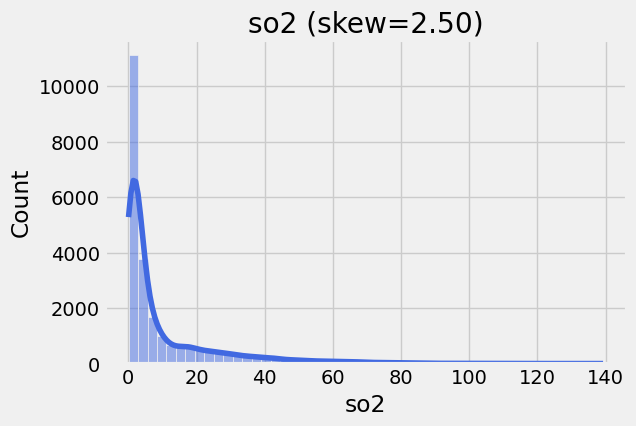

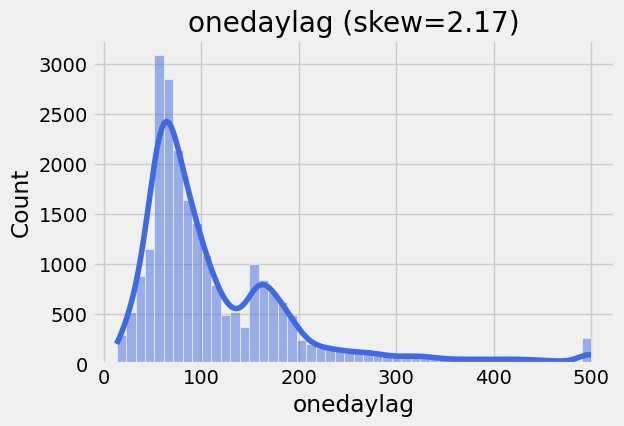

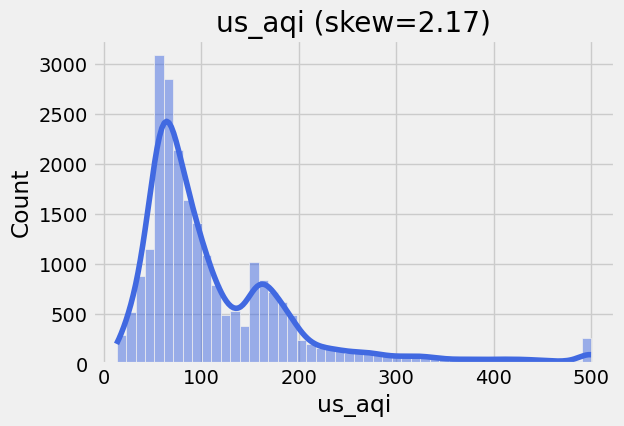

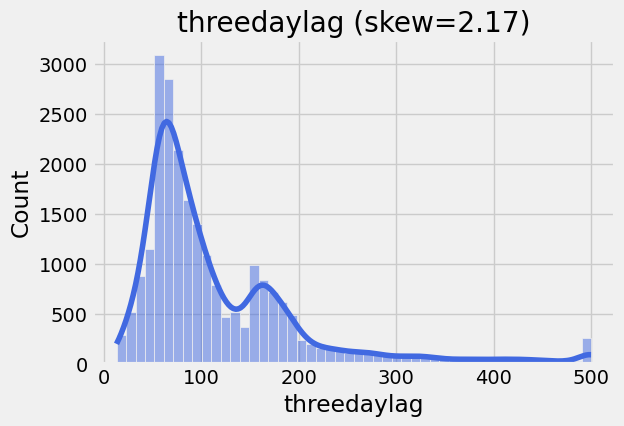

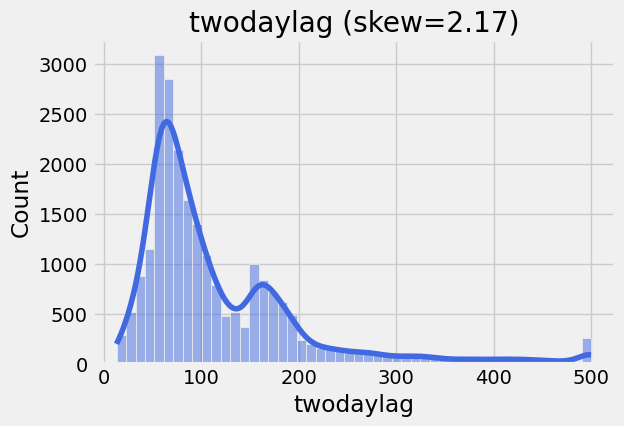

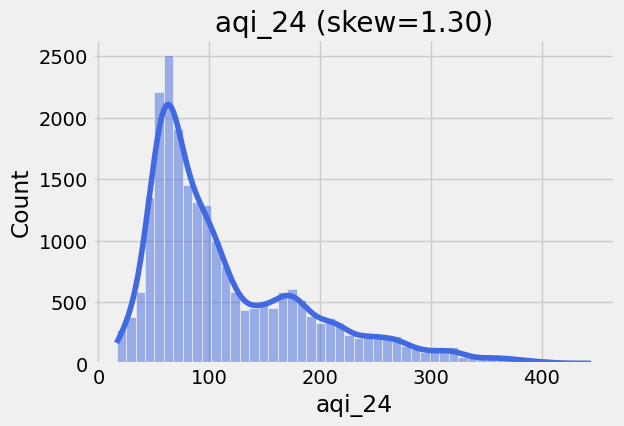

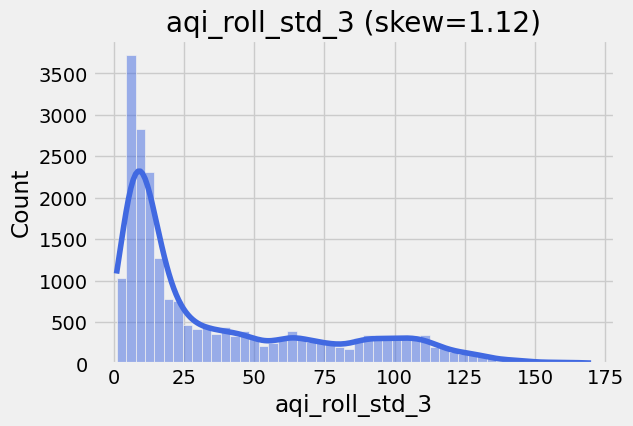

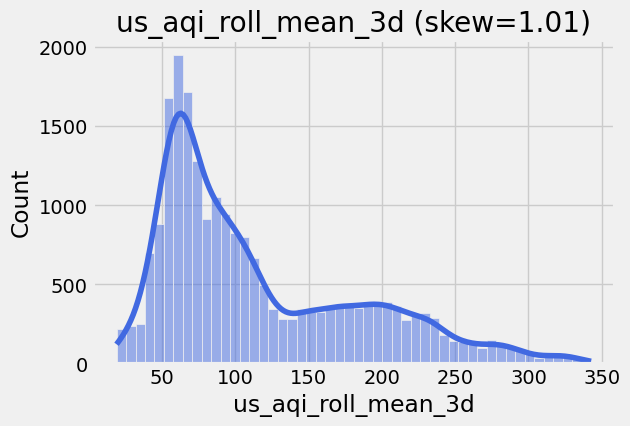

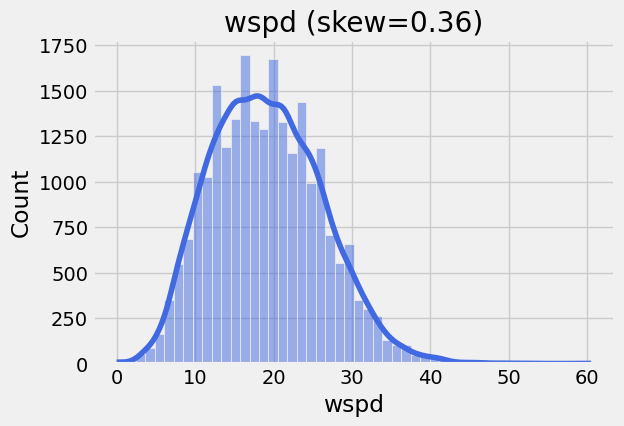

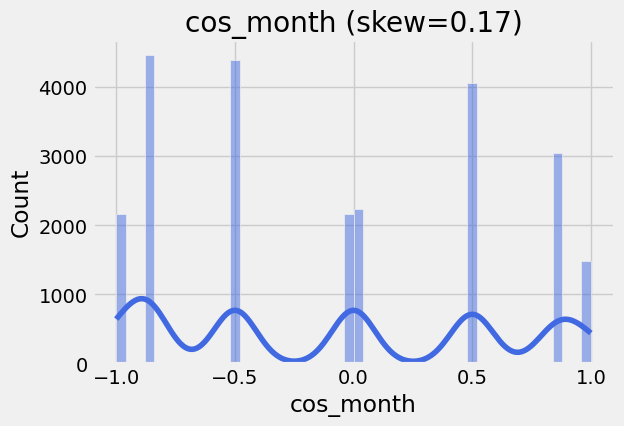

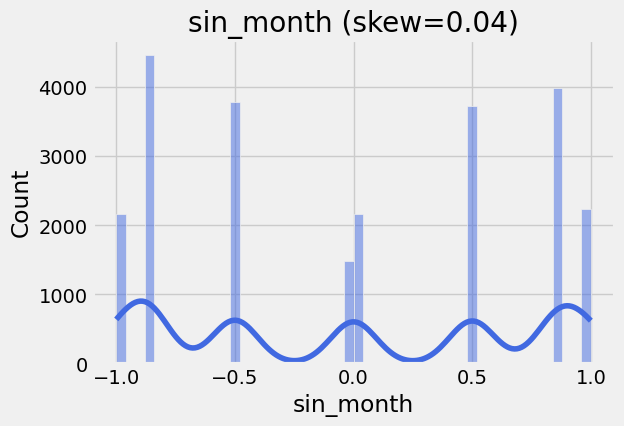

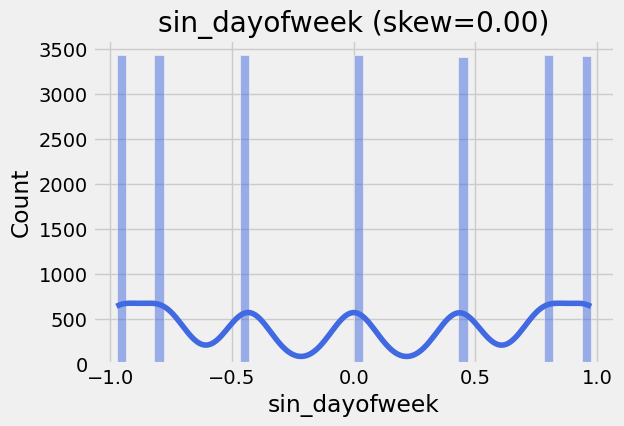

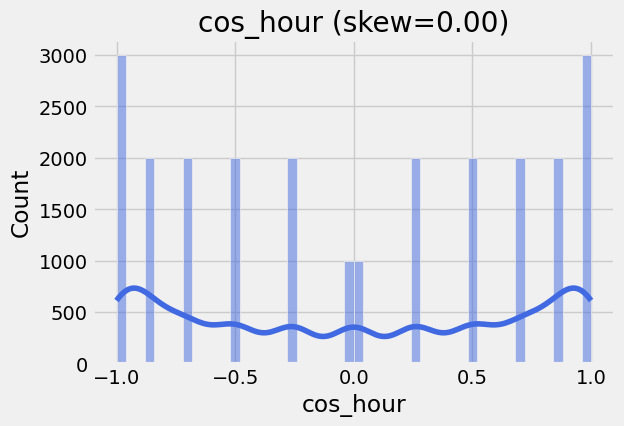

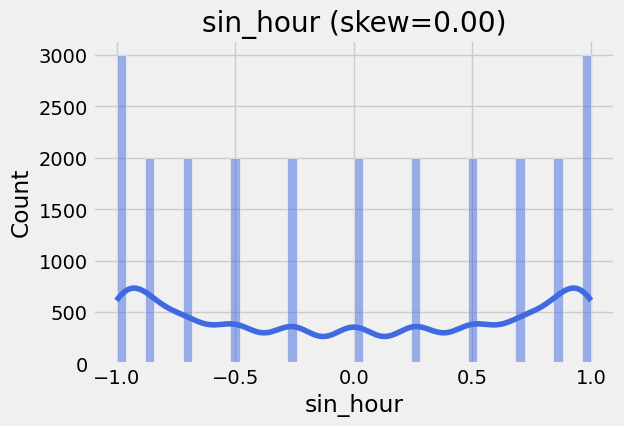

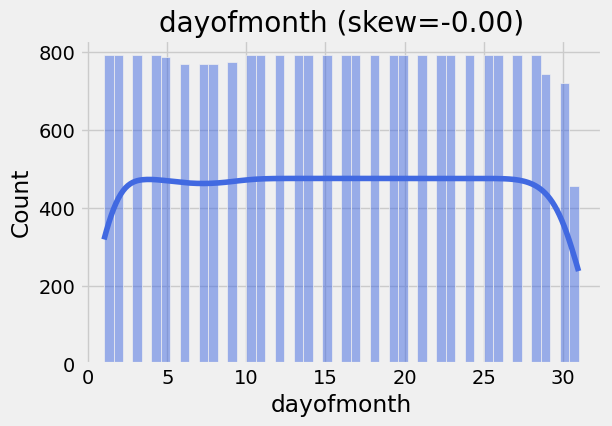

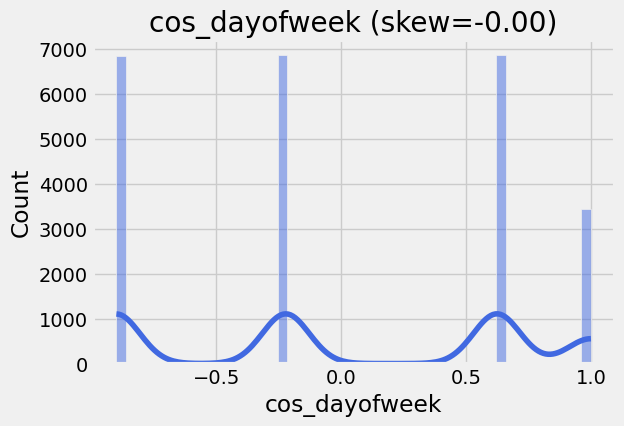

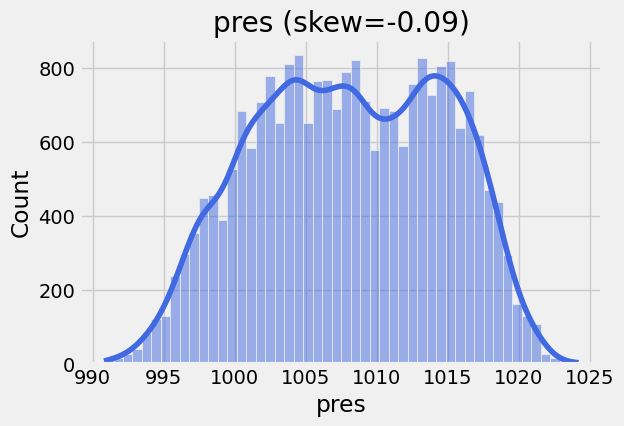

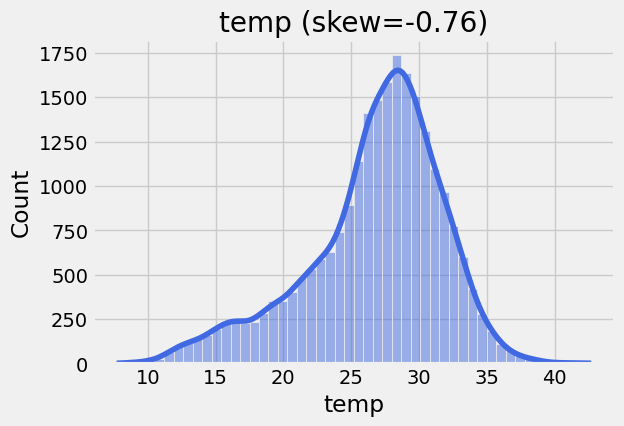

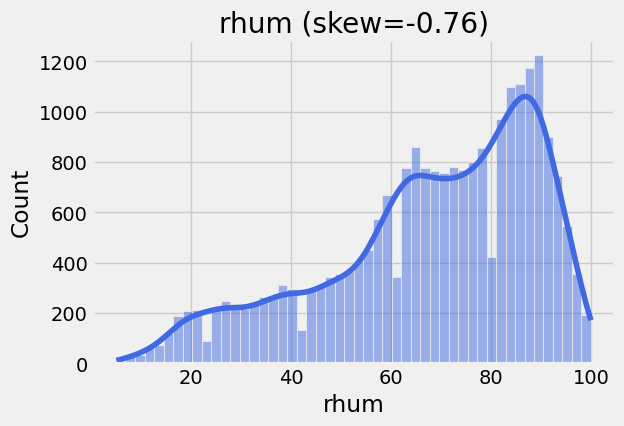

In [58]:
skew_vals = data.skew(numeric_only=True).sort_values(ascending=False)
skewed_cols = skew_vals.index
for col in skewed_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, bins=50, color="royalblue")
    plt.title(f"{col} (skew={data[col].skew():.2f})")
    plt.show()

In [59]:
print(data[skewed_cols].skew())

no2_temp                4.25049
pm2_5_rhum             4.165823
pm2_5                  3.895966
pm10                     3.3394
no2                    3.233641
so2                    2.502546
onedaylag               2.16743
us_aqi                 2.167373
threedaylag            2.167206
twodaylag              2.166823
aqi_24                 1.297926
aqi_roll_std_3         1.124868
us_aqi_roll_mean_3d     1.00541
wspd                   0.360307
cos_month              0.166719
sin_month              0.037364
sin_dayofweek          0.001586
cos_hour                    0.0
sin_hour                    0.0
dayofmonth            -0.000898
cos_dayofweek         -0.001544
pres                  -0.089223
temp                  -0.759394
rhum                  -0.763976
dtype: Float64


In [60]:
data = data.dropna()

In [61]:
data = data.drop(columns=['aqi_24'])

In [62]:
data.columns

Index(['no2', 'so2', 'pm2_5', 'pm10', 'temp', 'rhum', 'wspd', 'pres', 'us_aqi',
       'dayofmonth', 'sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek',
       'sin_month', 'cos_month', 'onedaylag', 'twodaylag', 'threedaylag',
       'aqi_roll_std_3', 'us_aqi_roll_mean_3d', 'pm2_5_rhum', 'no2_temp'],
      dtype='object')

In [63]:
print(data)

                       no2    so2  pm2_5    pm10  temp  rhum  wspd    pres  \
timestamp                                                                    
2023-02-13 17:00:00  40.78  15.14  96.17  156.50  20.3  69.0  16.6  1018.2   
2023-02-13 18:00:00  36.67  13.71  92.41  151.22  19.8  73.0  16.9  1018.4   
2023-02-13 19:00:00  31.53  10.97  78.18  133.58  19.4  77.0  15.8  1018.0   
2023-02-13 20:00:00  22.62   8.46  59.88  109.76  19.2  80.0  16.9  1017.2   
2023-02-13 21:00:00  14.74   7.75  53.57  101.02  19.0  84.0  18.4  1016.7   
...                    ...    ...    ...     ...   ...   ...   ...     ...   
2025-11-04 13:00:00   0.44   1.06  61.98  247.20  26.8  36.0  17.6  1008.9   
2025-11-04 14:00:00   0.45   1.03  62.65  250.88  25.5  40.0  16.9  1009.3   
2025-11-04 15:00:00   0.43   0.92  61.00  245.85  24.4  45.0  18.4  1009.8   
2025-11-04 16:00:00   0.42   0.76  59.09  242.07  23.8  44.0  20.9  1010.2   
2025-11-04 17:00:00   0.41   0.60  59.12  249.51  23.3  20.0  18

**Feature Saving Process**

In [64]:
data = data.sort_index()

In [65]:
import hopsworks
def save_to_feature_store(df,name,description,vers,api_key):
    project = hopsworks.login(api_key_value=api_key)
    fs = project.get_feature_store()
    fg = fs.get_or_create_feature_group(
        name=name,
        version=vers,
        primary_key=["timestamp"],
        description=description
    )
    fg.insert(df, write_options={"wait_for_job": True})
    print("Saved features to Hopsworks Feature Store")

In [66]:
data = data.reset_index()
save_to_feature_store(data,"aqi_feature","Features for AQI prediction",1,userdata.get("HOPSWORKS_API_KEY"))


Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1251483


Uploading Dataframe: 100.00% |██████████| Rows 21441/21441 | Elapsed Time: 00:07 | Remaining Time: 00:00


Launching job: aqi_feature_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1251483/jobs/named/aqi_feature_1_offline_fg_materialization/executions
Saved features to Hopsworks Feature Store


**Model
Training**

In [67]:
#Load Features
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY)
fs = project.get_feature_store()
fg = fs.get_feature_group("aqi_feature", version=1)
if fg:
  df = fg.read()
  df = df.set_index('timestamp')
  df.index = pd.to_datetime(df.index)
  df = df.sort_index()
else:
  print("No DataFrame Fetched!")

Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1251483
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.65s) 


In [68]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3, test_size=1000, gap=0)

In [69]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, make_scorer
)
import xgboost as xgb
import lightgbm as lgb

In [70]:
def create_targets_full(df):
  df['aqi_24'] = df['us_aqi'].rolling(window=24).mean().shift(-24)
  df['aqi_48'] = df['us_aqi'].rolling(window=48).mean().shift(-48)
  df['aqi_72'] = df['us_aqi'].rolling(window=72).mean().shift(-72)
  return df

Finding Ideal Parameters

In [71]:
results = []

In [72]:
models = {
    "RandomForest":RandomForestRegressor(n_estimators=2000, max_depth=10, min_samples_split=5),
    "xgb":xgb.XGBRegressor(n_estimators=2000,learning_rate=0.01,max_depth=8),
    "lgbm":lgb.LGBMRegressor(n_estimators=2000,learning_rate=0.01,num_leaves=64,max_depth=-1,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.2,reg_lambda=0.2,min_child_samples=30,random_state=42,n_jobs=-1)
}

In [73]:
df2 = df.copy()

In [74]:
cols_to_transform = ['pm2_5', 'pm10', 'no2', 'so2','onedaylag', 'twodaylag', 'threedaylag','pm2_5_rhum','no2_temp']

In [75]:
df2 = create_targets(df2)
df2 = df2.drop(columns=['us_aqi'])
df2 = df2.dropna()

for model_name, model in models.items():
    print(f"Training {model_name}...")
    preds, rmse_scores, mae_scores, r2_scores = [], [], [], []
    fold = 0

    for train_idx, val_idx in tss.split(df2):
        train = df2.iloc[train_idx].copy()
        test = df2.iloc[val_idx].copy()

        # Separate features/targets
        features = [
            'pm2_5', 'pm10', 'no2', 'so2',
            'onedaylag', 'twodaylag', 'threedaylag',
            'aqi_roll_std_3', 'us_aqi_roll_mean_3d',
            'pm2_5_rhum', 'no2_temp',
            'temp', 'rhum', 'pres', 'wspd',
            'sin_hour', 'cos_hour',
            'sin_dayofweek', 'cos_dayofweek',
            'sin_month', 'cos_month',
        ]
        target = 'aqi_24'

        X_train, y_train = train[features], train[target]
        X_test, y_test = test[features], test[target]

        # --- Apply PowerTransformer safely ---
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        X_train_tf = X_train.copy()
        X_test_tf = X_test.copy()
        X_train_tf[cols_to_transform] = pt.fit_transform(X_train_tf[cols_to_transform])
        X_test_tf[cols_to_transform] = pt.transform(X_test_tf[cols_to_transform])

        # --- Then scale ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_tf)
        X_test_scaled = scaler.transform(X_test_tf)

        pt_y = PowerTransformer(method='yeo-johnson')
        y_train_tf = pt_y.fit_transform(y_train.values.reshape(-1,1)).ravel()

        model.fit(X_train_scaled, y_train_tf)
        y_pred_tf = model.predict(X_test_scaled)
        y_pred = pt_y.inverse_transform(y_pred_tf.reshape(-1,1)).ravel()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Fold {fold}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        preds.append((y_test.values, y_pred))
        fold += 1

    results.append({
        "Model": model_name,
        "RMSE": np.mean(rmse_scores),
        "MAE": np.mean(mae_scores),
        "R2": np.mean(r2_scores)
    })


Training RandomForest...
Fold 0: RMSE=8.343, MAE=6.600, R²=0.822
Fold 1: RMSE=10.931, MAE=8.747, R²=0.631
Fold 2: RMSE=16.764, MAE=12.646, R²=0.894
Training xgb...
Fold 0: RMSE=8.875, MAE=6.976, R²=0.798
Fold 1: RMSE=11.829, MAE=9.355, R²=0.568
Fold 2: RMSE=17.127, MAE=13.109, R²=0.889
Training lgbm...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 18510, number of used features: 21
[LightGBM] [Info] Start training from score -0.000000


Fold 0: RMSE=8.442, MAE=6.680, R²=0.817
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 19510, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


Fold 1: RMSE=11.596, MAE=9.122, R²=0.584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 20510, number of used features: 21
[LightGBM] [Info] Start training from score -0.000000


Fold 2: RMSE=15.220, MAE=11.728, R²=0.913


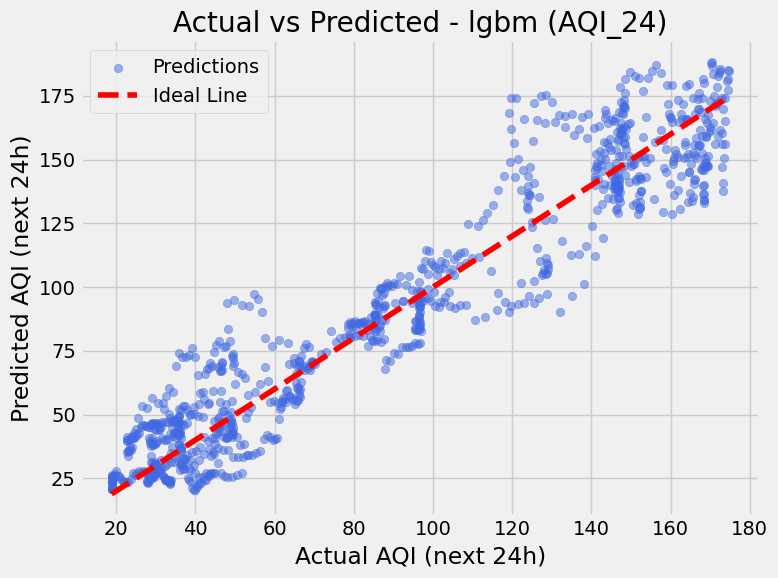


Best Model: lgbm
       Model      RMSE      MAE       R2
RandomForest 12.012505 9.331104 0.782127
         xgb 12.610045 9.813469 0.751713
        lgbm 11.752731 9.176450 0.771479


In [76]:
y_test_last, y_pred_last = preds[-1]
targets_names = 'aqi_24'
colors = 'royal_blue'

# --- Plot Actual vs Predicted for AQI_24 ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test_last, y_pred_last, alpha=0.5, color='royalblue', label='Predictions')
plt.plot([y_test_last.min(), y_test_last.max()],
         [y_test_last.min(), y_test_last.max()],
         color='red', linestyle='--', label='Ideal Line')

plt.xlabel("Actual AQI (next 24h)")
plt.ylabel("Predicted AQI (next 24h)")
plt.title(f"Actual vs Predicted - {model_name} (AQI_24)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
best_row = results_df.sort_values("RMSE").iloc[0]
best_model_name = best_row["Model"]

print("\nBest Model:", best_model_name)
print(results_df.to_string(index=False))

In [77]:
print(results)

[{'Model': 'RandomForest', 'RMSE': 12.012504698569805, 'MAE': 9.331104250235954, 'R2': 0.7821267892219049}, {'Model': 'xgb', 'RMSE': 12.610044825038926, 'MAE': 9.813469014909531, 'R2': 0.751713116266724}, {'Model': 'lgbm', 'RMSE': 11.752731440099453, 'MAE': 9.176449910811927, 'R2': 0.7714791202825113}]


Holdout evaluation on MultiOutput Targets

In [78]:
from sklearn.multioutput import MultiOutputRegressor

df2 = df.copy()
df2 = create_targets_full(df2)
df2 = df2.drop(columns=['us_aqi'])
df2 = df2.dropna()

holdout_size = int(len(df2) * 0.2)
train_df = df2.iloc[:-holdout_size]
test_df  = df2.iloc[-holdout_size:]

print(f"Train: {train_df.shape},  Test (Hold-out): {test_df.shape}")

features = [
            'pm2_5', 'pm10', 'no2', 'so2',
            'onedaylag', 'twodaylag', 'threedaylag',
            'aqi_roll_std_3', 'us_aqi_roll_mean_3d',
            'pm2_5_rhum', 'no2_temp',
            'temp', 'rhum', 'pres', 'wspd',
            'sin_hour', 'cos_hour',
            'sin_dayofweek', 'cos_dayofweek',
            'sin_month', 'cos_month',
        ]
targets = ['aqi_24','aqi_48','aqi_72']

X_train, y_train = train_df[features], train_df[targets]
X_test,  y_test  = test_df[features],  test_df[targets]

pt_X = PowerTransformer(method='yeo-johnson', standardize=False)
X_train_tf = X_train.copy()
X_test_tf  = X_test.copy()
X_train_tf[cols_to_transform] = pt_X.fit_transform(X_train_tf[cols_to_transform])
X_test_tf[cols_to_transform]  = pt_X.transform(X_test_tf[cols_to_transform])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tf)
X_test_scaled  = scaler.transform(X_test_tf)

pt_y = PowerTransformer(method='yeo-johnson')
y_train_tf = pt_y.fit_transform(y_train)

base_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.2,
    min_child_samples=30,
    random_state=42,
    n_jobs=-1
)
final_model = MultiOutputRegressor(base_model)
final_model.fit(X_train_scaled, y_train_tf)
print("Model trained on training split")

# === Predict on hold-out test ===
y_pred_tf = final_model.predict(X_test_scaled)
y_pred = pt_y.inverse_transform(y_pred_tf)

# === Evaluate ===
print("\nHold-out Evaluation:")
for i, col in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{col}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")


Train: (17170, 25),  Test (Hold-out): (4292, 25)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 17170, number of used features: 21
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 17170, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 17170, numbe


Hold-out Evaluation:
aqi_24: RMSE=19.128, MAE=12.321, R²=0.746
aqi_48: RMSE=22.074, MAE=15.418, R²=0.641
aqi_72: RMSE=22.392, MAE=16.368, R²=0.611


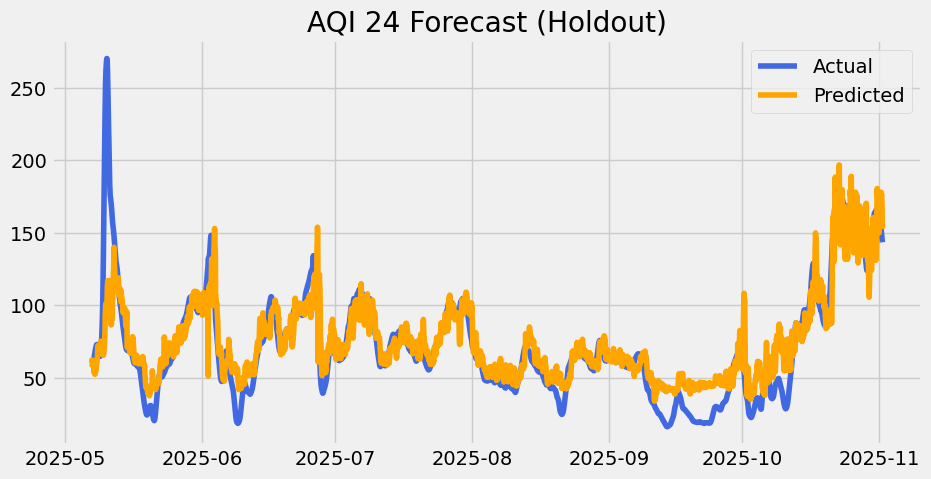

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test['aqi_24'], label='Actual', color='royalblue')
plt.plot(y_test.index, y_pred[:, 0], label='Predicted', color='orange')
plt.title('AQI 24 Forecast (Holdout)')
plt.legend()
plt.show()


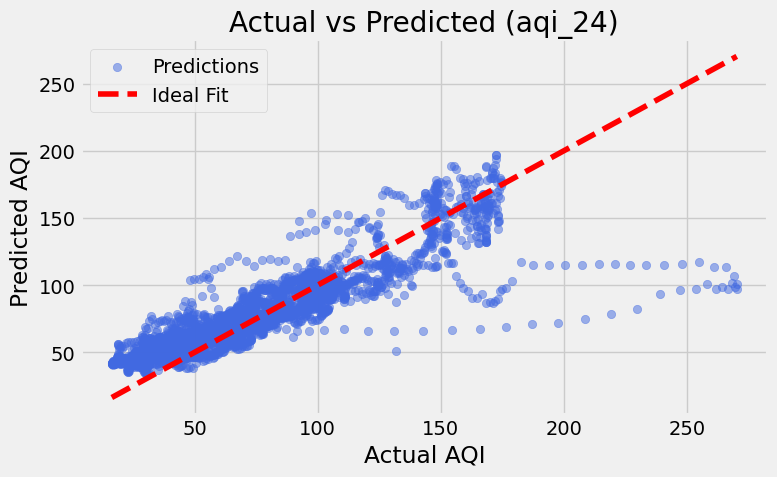

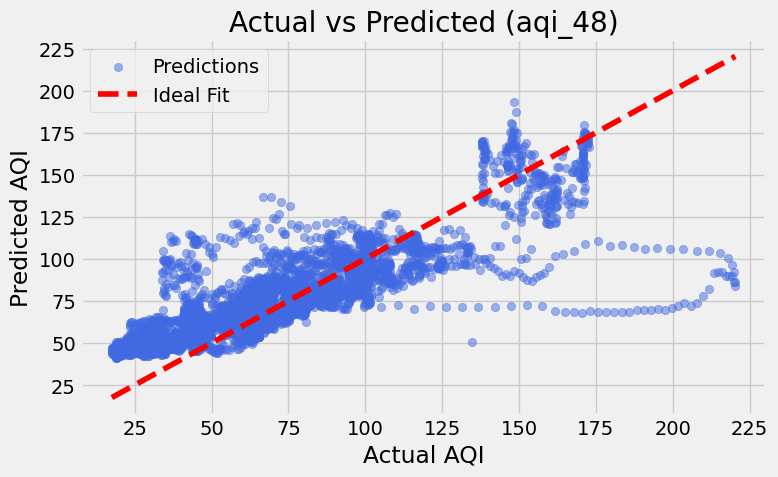

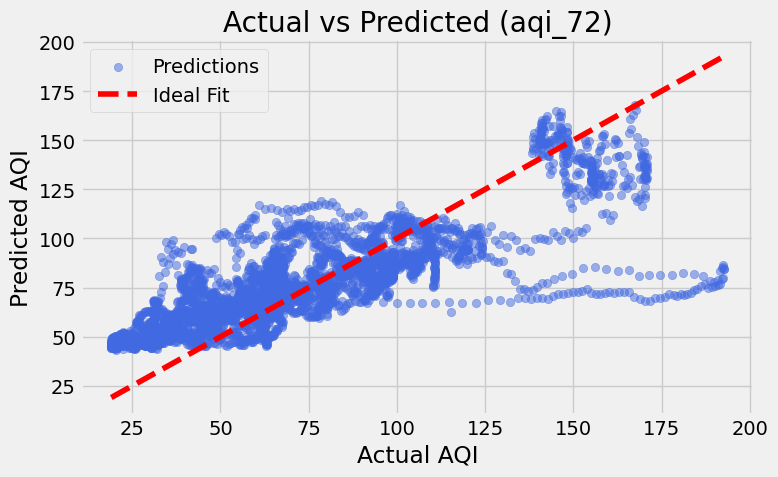

In [80]:
import matplotlib.pyplot as plt

for i, col in enumerate(['aqi_24', 'aqi_48', 'aqi_72']):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5, color='royalblue', label='Predictions')
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
             [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
             color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel("Actual AQI")
    plt.ylabel("Predicted AQI")
    plt.title(f"Actual vs Predicted ({col})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


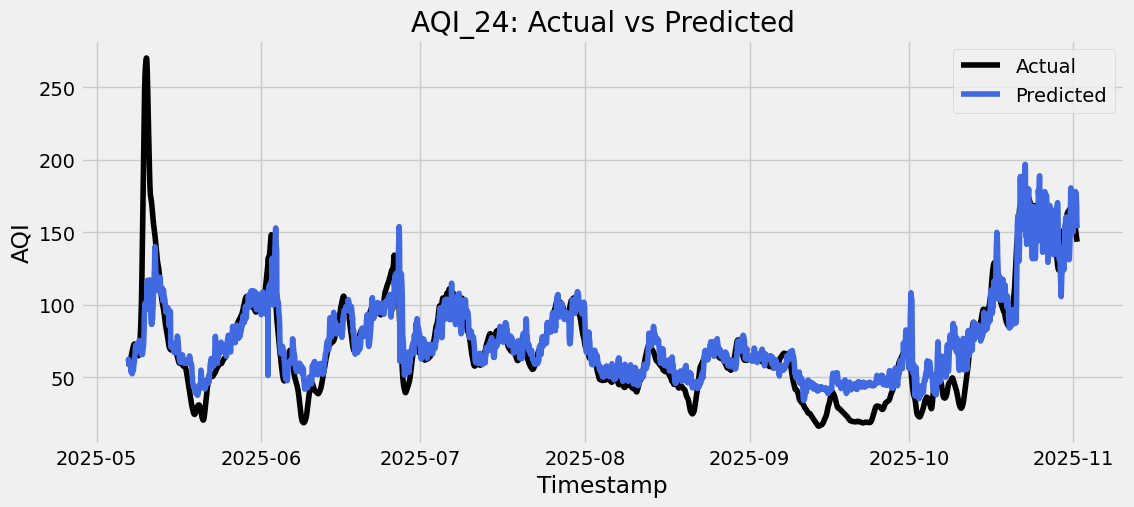

In [81]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index[-len(y_pred):], y_test['aqi_24'][-len(y_pred):], label='Actual', color='black')
plt.plot(y_test.index[-len(y_pred):], y_pred[:,0], label='Predicted', color='royalblue')
plt.title('AQI_24: Actual vs Predicted')
plt.xlabel('Timestamp')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()


Final Model Training (standard Data science practice)

In [82]:
df = df.copy()

In [83]:
from sklearn.multioutput import MultiOutputRegressor

# --- Prepare Data ---
df = df.sort_index()
df = create_targets_full(df)
df = df.dropna()

features = [
            'pm2_5', 'pm10', 'no2', 'so2',
            'onedaylag', 'twodaylag', 'threedaylag',
            'aqi_roll_std_3', 'us_aqi_roll_mean_3d',
            'pm2_5_rhum', 'no2_temp',
            'temp', 'rhum', 'pres', 'wspd',
            'sin_hour', 'cos_hour',
            'sin_dayofweek', 'cos_dayofweek',
            'sin_month', 'cos_month',
        ]
targets = ['aqi_24','aqi_48','aqi_72']

X = df[features]
y = df[targets]

cols_to_transform = ['pm2_5','pm10','no2','so2','onedaylag','twodaylag','threedaylag']

# --- Transformations ---
pt_X = PowerTransformer(method='yeo-johnson', standardize=False)
X_tf = X.copy()
X_tf[cols_to_transform] = pt_X.fit_transform(X_tf[cols_to_transform])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tf)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

pt_y = PowerTransformer(method='yeo-johnson')
y_tf = pt_y.fit_transform(y)

# --- Model ---
base_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.2,
    min_child_samples=30,
    random_state=42,
    n_jobs=-1
)

final_model = MultiOutputRegressor(base_model)
final_model.fit(X_scaled, y_tf)
print("Final MultiOutput model trained on all data")

y_pred_tf = final_model.predict(X_scaled)
y_pred = pt_y.inverse_transform(y_pred_tf)

for i, col in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y.iloc[:, i], y_pred[:, i]))
    mae = mean_absolute_error(y.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y.iloc[:, i], y_pred[:, i])
    print(f"{col} → RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

# --- Save ---
joblib.dump(final_model, "final_lgbm_multioutput.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pt_X, "feature_power_transformer.pkl")
joblib.dump(pt_y, "target_power_transformer.pkl")
print("Model + transformers saved.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 21462, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 21462, number of used features: 21
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 21462, number of used features: 21
[LightGBM] [Info] Start tr

aqi_24 → RMSE=10.839, MAE=6.324, R²=0.979
aqi_48 → RMSE=8.932, MAE=5.491, R²=0.984
aqi_72 → RMSE=8.065, MAE=4.995, R²=0.986
Model + transformers saved.


Frontend Dashboard on Gradio

In [100]:
from PIL import Image

def fig_to_image(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    img = Image.open(buf)
    plt.close(fig)
    return img

In [109]:
def get_aqi_category(aqi):
    if aqi <= 50: return "Good", "green"
    elif aqi <= 100: return "Moderate", "yellow"
    elif aqi <= 150: return "Unhealthy for Sensitive Groups", "orange"
    elif aqi <= 200: return "Unhealthy", "red"
    elif aqi <= 300: return "Very Unhealthy", "purple"
    else: return "Hazardous", "maroon"

In [113]:
project = hopsworks.login(api_key_value=userdata.get("HOPSWORKS_API_KEY"))


Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1251483


In [119]:
import gradio as gr
import joblib, os, io
from datetime import datetime, timedelta
import hopsworks

model = joblib.load("final_lgbm_multioutput.pkl")
scaler = joblib.load("scaler.pkl")
pt_X = joblib.load("feature_power_transformer.pkl")
pt_y = joblib.load("target_power_transformer.pkl")

def predict_aqi_dashboard():
    city_name = "Karachi"
    try:
        fs = project.get_feature_store()
        fg = fs.get_feature_group("aqi_feature", version=1)
        df = fg.read()
        df = df.set_index('timestamp')
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
    except Exception as e:
        return f"<b style='color:#FF6B6B'>⚠️ Error fetching from Feature Store: {e}</b>", None, None, None

    features = [
            'pm2_5', 'pm10', 'no2', 'so2',
            'onedaylag', 'twodaylag', 'threedaylag',
            'aqi_roll_std_3', 'us_aqi_roll_mean_3d',
            'pm2_5_rhum', 'no2_temp',
            'temp', 'rhum', 'pres', 'wspd',
            'sin_hour', 'cos_hour',
            'sin_dayofweek', 'cos_dayofweek',
            'sin_month', 'cos_month',
    ]
    cols_to_transform = ['pm2_5','pm10','no2','so2','onedaylag','twodaylag','threedaylag']

    X = df[features].tail(1)
    X_tf = X.copy()
    X_tf[cols_to_transform] = pt_X.transform(X_tf[cols_to_transform])
    X_scaled = scaler.transform(X_tf)
    X_scaled = pd.DataFrame(X_scaled, columns=X_tf.columns)
    y_pred_tf = model.predict(X_scaled)
    y_pred = pt_y.inverse_transform(y_pred_tf)
    preds = {"24h": y_pred[0,0], "48h": y_pred[0,1], "72h": y_pred[0,2]}

    # Forecast Plot
    df_preds = pd.DataFrame({
        "Hours Ahead": [24, 48, 72],
        "Predicted AQI": [preds["24h"], preds["48h"], preds["72h"]],
    })
    plt.style.use("dark_background")
    fig1, ax1 = plt.subplots(figsize=(6,4), facecolor="#0B132B")
    ax1.plot(df_preds["Hours Ahead"], df_preds["Predicted AQI"], marker="o", color="#00B4D8", linewidth=2.5)
    ax1.set_title(f"AQI Forecast for {city_name.title()}", fontsize=14, fontweight='bold', color="#F1F1F1")
    ax1.set_xlabel("Hours Ahead", fontsize=11, color="#B0BEC5")
    ax1.set_ylabel("Predicted AQI", fontsize=11, color="#B0BEC5")
    img1 = fig_to_image(fig1)

    # Recent Trend Plot
    df_recent = df.tail(48)
    fig2, ax2 = plt.subplots(figsize=(6,4), facecolor="#0B132B")
    ax2.plot(df_recent.index, df_recent["us_aqi"], color="#FFD166", linewidth=2)
    ax2.set_title("Recent AQI Trend (Past 48h)", fontsize=13, fontweight='bold', color="#F1F1F1")
    ax2.set_xlabel("Time", fontsize=11, color="#B0BEC5")
    ax2.set_ylabel("AQI", fontsize=11, color="#B0BEC5")
    plt.xticks(rotation=30)
    img2 = fig_to_image(fig2)

    # AQI Card
    cat, color = get_aqi_category(preds["24h"])
    status_html = f"""
    <div style='padding: 25px; border-radius: 15px; background:{color}; color:#0B132B; text-align:center; font-family:Inter, sans-serif'>
        <h2 style='margin:0;'>🌫️ Current AQI Category</h2>
        <h1 style='margin:5px 0; font-size:42px; font-weight:800'>{cat}</h1>
        <h3>Predicted AQI (Next 24h): {preds["24h"]:.1f}</h3>
    </div>
    """

    return status_html, img1, img2, df_preds

# === Custom CSS ===
css = """
.gradio-container {
    background: linear-gradient(145deg, #0B132B, #1C2541);
    color: #E0E0E0;
    font-family: 'Inter', sans-serif;
}
label, h1, h2, h3, p, .gr-button {
    color: #E0E0E0 !important;
}
button {
    background-color: #5A4FCF !important;
    border: none !important;
    font-weight: 600 !important;
    border-radius: 12px !important;
    transition: 0.2s ease-in-out;
}
button:hover {
    background-color: #7369F5 !important;
    transform: scale(1.03);
}
input {
    background-color: #1C2541 !important;
    border: 1px solid #3A506B !important;
    color: #F1F1F1 !important;
    border-radius: 10px !important;
}
.gr-box, .gr-panel, .gr-compact {
    background-color: #1C2541 !important;
    border-radius: 15px !important;
    border: 1px solid #3A506B !important;
}

/* --- Dataframe styling --- */
.dataframe {
    background-color: #0E1628 !important;
    border-radius: 10px !important;
    border: 1px solid #263E5A !important;
    color: #E0E0E0 !important;
}
.dataframe td, .dataframe th {
    border: none !important;
    text-align: center !important;
    font-size: 15px !important;
    font-weight: 600 !important;
    padding: 12px 16px !important;
    background-color: #1A2238 !important;
    color: #E8E8FF !important;
}
.dataframe th {
    background-color: #27355B !important;
    color: #BFC8F8 !important;
}
.dataframe td {
    border-radius: 8px !important;
}
.dataframe td input {
    width: 160px !important;  /* wider columns */
    height: 38px !important;  /* more rectangular height */
    border-radius: 6px !important; /* subtle rounding */
    background-color: #4C47C0 !important;
    color: white !important;
    font-weight: 600 !important;
    text-align: center !important;
}

/* Remove excess space */
.gr-row {
    margin-top: 12px !important;
    margin-bottom: 12px !important;
}

footer {display: none !important;}
"""

# === Gradio App ===
with gr.Blocks(css=css, theme="gradio/soft") as app:
    gr.HTML("""
    <div style='background:#1F2A47; color:white; padding:25px; border-radius:15px; text-align:center;'>
        <h1 style='margin:0; font-size:34px; letter-spacing:0.5px;'>🌍 Karachi Pearls AQI Predictor Dashboard</h1>
        <p style='margin:5px 0 0 0; font-size:16px; color:#D1D5DB;'>Monitor and forecast Air Quality Index trends using Machine Learning and real-time Hopsworks data.</p>
    </div>
    """)
    with gr.Row(equal_height=True):
      run_button = gr.Button("🔮 Predict AQI for Karachi", variant="primary")

    with gr.Row():
        aqi_card = gr.HTML(label="🌫️ AQI Category")

    with gr.Row(equal_height=True):
        with gr.Column(scale=1):
            forecast_img = gr.Image(label="📊 AQI Forecast (Next 3 Days)")
        with gr.Column(scale=1):
            trend_img = gr.Image(label="🕒 Recent AQI Trend (Past 48h)")

    with gr.Row():
        df_output = gr.Dataframe(label="📅 Predicted AQI Levels", wrap=True)

    run_button.click(
        predict_aqi_dashboard,
        inputs=[],
        outputs=[aqi_card, forecast_img, trend_img, df_output]
    )

app.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://72233a52e1eed76bf4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.48s) 


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://72233a52e1eed76bf4.gradio.live
